In [ ]:
# default_exp funcs.routines

In [ ]:
%load_ext autoreload
%autoreload 2

# Visualization tools 

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.visualization import *
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.point_process import PointProcessUniform

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
def load_all(cfg, sl=False):
    path = Path(cfg.output.save_dir)/'sl_save' if sl else Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.model)
    model = load_model_state(model, path, 'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    psf, noise, micro = load_psf_noise_micro(cfg)
    psf.load_state_dict(torch.load(path/'psf.pkl'))
    if not sl:
        micro.load_state_dict(torch.load(path/'microscope.pkl'))
    psf.cuda()
    img_3d, decode_dl = get_dataloader(cfg)
    
    return model, post_proc, psf, micro, img_3d, decode_dl

In [ ]:
def sim_data(decode_dl, batches):
    
    gt_dfs = []
    xsim_col = []
    
    for _ in range(batches):
        x, local_rate, background = next(iter(decode_dl))
        sim_vars = PointProcessUniform(local_rate).sample()
        xsim = micro(*sim_vars)
        x = micro.noise(xsim, background).sample()
        
        xsim_col.append(x)
        gt_vars = filt_sim_vars(*sim_vars[:-1], micro.int_mu, micro.int_sig, micro.min_fac)
        gt_dfs.append(sample_to_df(*gt_vars, px_size=[1.,1.,1.]))
        
    return torch.cat(xsim_col), cat_emitter_dfs(gt_dfs)

def get_sim_perf(x, gt_df, model, post_proc, micro, cuda=True, print_res=True):

    pred_dfs = []
    x_recs = []
    
    for i in range(len(x)):
        
        pred_df, rec, res_dict = get_prediction(model, post_proc, x[i:i+1], micro=micro, cuda=True, return_rec=True, min_int=-100)
        pred_dfs.append(pred_df)
        x_recs.append(rec)
        
    pred_df = cat_emitter_dfs(pred_dfs)
    xrec = torch.cat(x_recs)
    perf, matches, _ = matching(gt_df, pred_df, tolerance=500, print_res=print_res)
    perf['mae'] = abs(xrec-rec).mean().item()
    perf['rmse'] = torch.sqrt(((xrec-rec)**2).mean()).item()
    
    return perf, pred_df, matches

In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f2/int_mu:4.0/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/nb_run/sim_density_fac1_5/train.yaml')
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f3/min_fac:0.3/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f4/min_fac:0.1/train.yaml')
cfg.foci.n_foci_avg = 0
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)

20 volumes


In [ ]:
# cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/nb_run/sim_density_fac1_2/train.yaml')
# model = load_model_state(model, Path(cfg.output.save_dir)/'sl_save', 'model.pkl')

In [ ]:
xsim, gt = sim_data(decode_dl, 10)
perf, pred_df, matches = get_sim_perf(xsim, px_to_nm(gt, cfg.evaluation.px_size), model, post_proc, micro, print_res=True)

ValueError: too many values to unpack (expected 6)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(gt['int'], bins=np.linspace(-3,3,31))
plt.hist(pred_df['int'],alpha=0.5, bins=np.linspace(-3,3,31))
plt.subplot(122)
plt.scatter(matches['int_tar'],matches['int_pred'])

In [ ]:
def sig_filt(df, perc = 90, return_low=True):
    if perc >= 100:
        return df
    filt_val = np.percentile(df['comb_sig'], perc)
    if return_low:
        return df[df['comb_sig'] < filt_val]
    else:
        return df[df['comb_sig'] > filt_val]


In [ ]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f4/min_fac:0.4/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f5/int_mu:4.0//train.yaml')
model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)

20 volumes


In [ ]:
# post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold = 0.7)

Recall: 0.936
Precision: 0.976
Jaccard: 91.477
RMSE_vol: 41.453
Eff_3d: 77.590
FN: 11.0 FP: 4.0
Shift: 6.15,-3.07,-0.28
0.9593023255813954


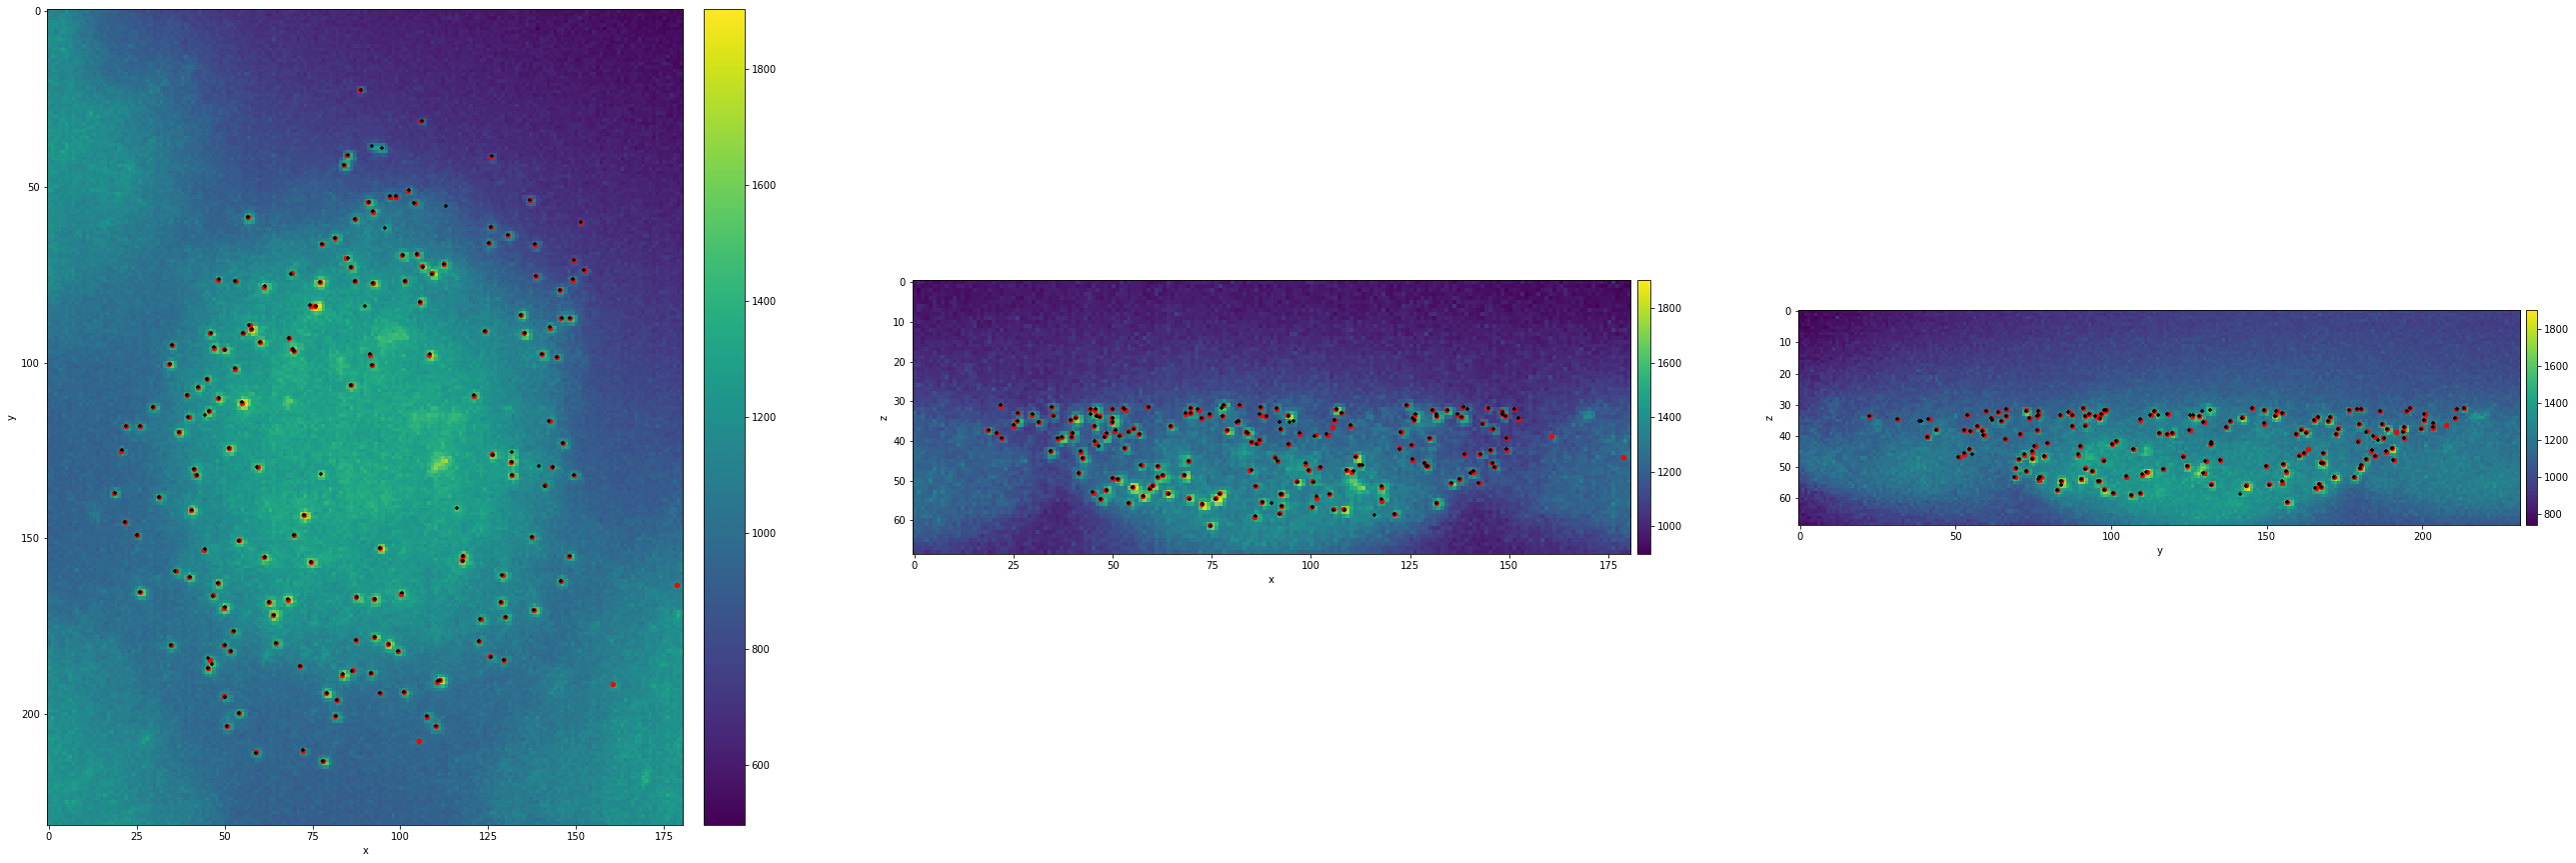

In [ ]:
model.cuda()
ind = 0
sl = np.s_[:,:,:,:]
# sl = np.s_[:,30:,150:180,115:135]
# basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'
# img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', ind)

basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_1/'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', ind)
gt_df = crop_df(gt_df, sl, px_size=[300,100,100])
fq_gmm_df = crop_df(fq_gmm_df, sl, px_size=[300,100,100])

axes = plot_3d_projections(img[sl][0], 'max', size=15)
with torch.no_grad():
    dec_df = shift_df(post_proc(model(img[sl][None].cuda()), 'df'), [-90,-80,-250])
#     dec_df = sig_filt(dec_df, 80)

scat_3d_projections(axes, [dec_df, gt_df], px_size_zyx=[300,100,100])

perf_df, matches, _ = matching(gt_df, dec_df, print_res=True)
print(len(dec_df)/len(gt_df))

169


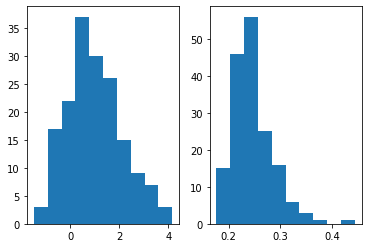

In [ ]:
plt.subplot(121)
print(len(dec_df))
ints = dec_df['int']+micro.int_mu.item()
# plt.hist(dec_df['int']+micro.int_mu.item())
_ = plt.hist(ints)
plt.subplot(122)
_ =plt.hist(dec_df['comb_sig'])

161


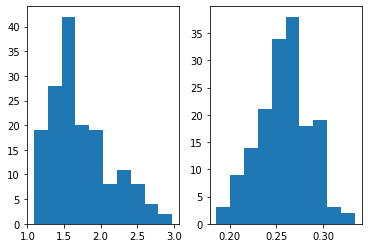

In [ ]:
plt.subplot(121)
print(len(dec_df))
ints = cfg.microscope.multipl*cpu(torch.sigmoid(torch.tensor(dec_df['int'].values)))
# plt.hist(dec_df['int']+micro.int_mu.item())
_ = plt.hist(ints)
plt.subplot(122)
_ = plt.hist(dec_df['comb_sig'])

In [ ]:
from decode_fish.funcs.fit_psf import get_peaks_3d
from decode_fish.funcs.fit_psf import plot_detection
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_foci_fac1_1//'

mults = [3.,4.,5.]

dec_count_col = []
prob_sum_col = []

for m in mults:
        
    cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/Fig_sim_density/sweep_f6/int_mu:{m}//train.yaml')
    model, post_proc, psf, micro, img_3d, decode_dl = load_all(cfg, False)
    _ = model.cuda()

    box_sz = 10
    n_cells = 20
    gt_counts = []
    fq_counts = []
    dec_counts = []
    prob_sums = []

    for i in tqdm(range(n_cells)):

        img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 100, 'foci', 'strong', i)
        gt_px = nm_to_px(gt_df, px_size=[100,100,300])
        fq_px = nm_to_px(fq_gmm_df, px_size=[100,100,300])
        with torch.no_grad():
            res_dict = model(img[None].cuda())
            dec_df = shift_df(post_proc(res_dict, 'df'), [-100,-100,-100])
            free_mem()
        dec_px = nm_to_px(dec_df, px_size=[100,100,300])

        try:
            coords_xyz = get_peaks_3d(img[0], threshold=2000, min_distance=10)
        except AssertionError:
            continue
        coords_zyx = coords_xyz[:,::-1]

        for c in coords_zyx:
            sl = np.s_[:,c[0]-box_sz:c[0]+box_sz+1, c[1]-box_sz:c[1]+box_sz+1, c[2]-box_sz:c[2]+box_sz+1]
            gt_crop = crop_df(gt_px, sl)
            fq_crop = crop_df(fq_px, sl)
            dec_crop = crop_df(dec_px, sl)
            prob_crop = torch.sigmoid(res_dict['logits'])[0][sl]

            gt_counts.append(len(gt_crop))
            fq_counts.append(len(fq_crop))
            dec_counts.append(len(dec_crop))
            prob_sums.append(prob_crop.sum().item())
            
    dec_count_col.append(dec_counts)
    prob_sum_col.append(prob_sums)

  0%|          | 0/20 [00:00<?, ?it/s]

20 volumes


  0%|          | 0/20 [00:00<?, ?it/s]

20 volumes


  0%|          | 0/20 [00:00<?, ?it/s]

20 volumes


100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


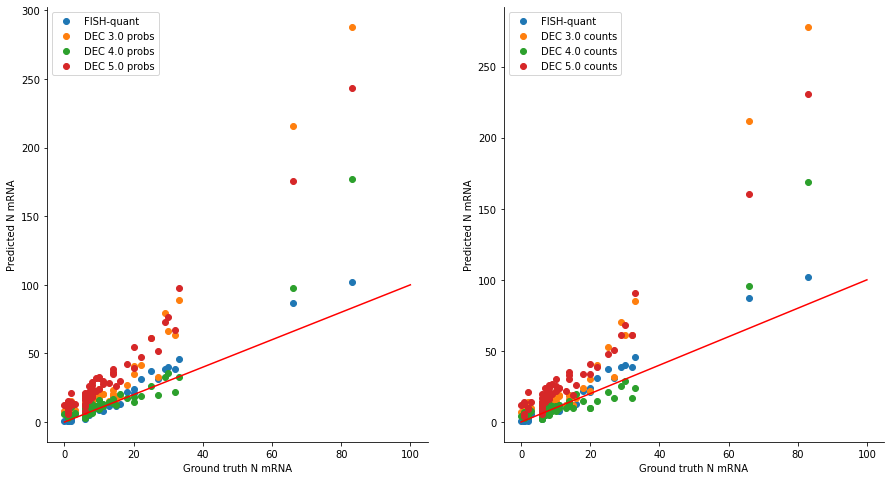

In [ ]:
plt.figure(figsize=(15,8))
import seaborn as sns
plt.subplot(121)
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
for i,c in enumerate(prob_sum_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} probs')
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()

plt.subplot(122)
plt.scatter(gt_counts, fq_counts, label='FISH-quant')

for i,c in enumerate(dec_count_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} counts')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()
# print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])

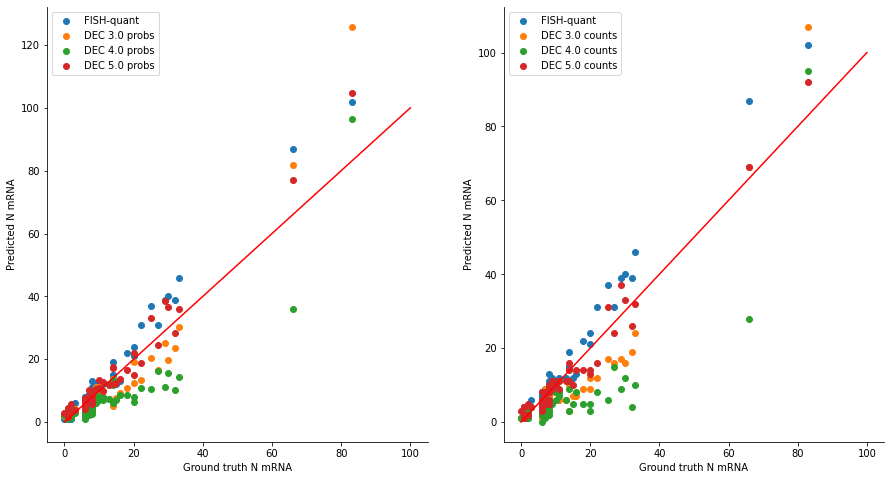

In [ ]:
plt.figure(figsize=(15,8))
import seaborn as sns
plt.subplot(121)
plt.scatter(gt_counts, fq_counts, label='FISH-quant')
for i,c in enumerate(prob_sum_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} probs')
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()

plt.subplot(122)
plt.scatter(gt_counts, fq_counts, label='FISH-quant')

for i,c in enumerate(dec_count_col):
    plt.scatter(gt_counts, c, label=f'DEC {mults[i]} counts')

plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.legend()
sns.despine()
# print('Corr. FQ: ', np.corrcoef([gt_counts, fq_counts])[0,1])
# print('Corr. DECODE: ', np.corrcoef([gt_counts, dec_counts])[0,1])


In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted index.ipynb.
